In [1]:
from utils_csa import save_obj, load_obj

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from pytz import timezone
from datetime import datetime, timedelta, date

# import all needed libraries
import sys
sys.path.append('/home/cysacenda/algocryptos/algocryptos_scripts/algo')
sys.path.append('/home/cysacenda/algocryptos/algocryptos_scripts/commons')
sys.path.append('/home/cysacenda/algocryptos/algocryptos_scripts/')
from trading.alg_order import AlgOrderFake
from trading.trading_pair import TradingPair
from trading.trading_api import TradingApi
from trading.trading_api_fake import TradingApiFake
from trading.trading_module import TradingModule
from trading.utils_ml import remove_id_index, format_both_close_prices, format_close_prices
from trading.backtesting_strategy import BacktestingStrategy

[BUY] ORDER PLACED (2018-09-21 20:00:00+00:00): 1835.0477590007347 XRP for 1000.0$ (close_price = 0.54$ / fees = 1.0)
[SELL] ORDER PLACED (2018-09-23 04:00:00+00:00): 1835.0477590007347 XRP for 1079.2123231080088$ (close_price = 0.59$ / fees = 1.08)
[BUY] ORDER PLACED (2018-10-07 20:00:00+00:00): 187.17588728904528 EOS for 1079.2123231080088$ (close_price = 5.76$ / fees = 1.08)
[SELL] ORDER PLACED (2018-10-08 21:00:00+00:00): 187.17588728904528 EOS for 1108.8430586124143$ (close_price = 5.93$ / fees = 1.11)
[BUY] ORDER PLACED (2018-10-14 21:00:00+00:00): 2634.952938995723 XRP for 1108.8430586124143$ (close_price = 0.42$ / fees = 1.11)
[SELL] ORDER PLACED (2018-10-16 01:00:00+00:00): 2634.952938995723 XRP for 1195.862061065571$ (close_price = 0.45$ / fees = 1.2)
[BUY] ORDER PLACED (2018-10-16 21:00:00+00:00): 2528.929295098445 XRP for 1195.862061065571$ (close_price = 0.47$ / fees = 1.2)
[SELL] ORDER PLACED (2018-10-18 01:00:00+00:00): 2528.929295098445 XRP for 1211.1563353661243$ (clos

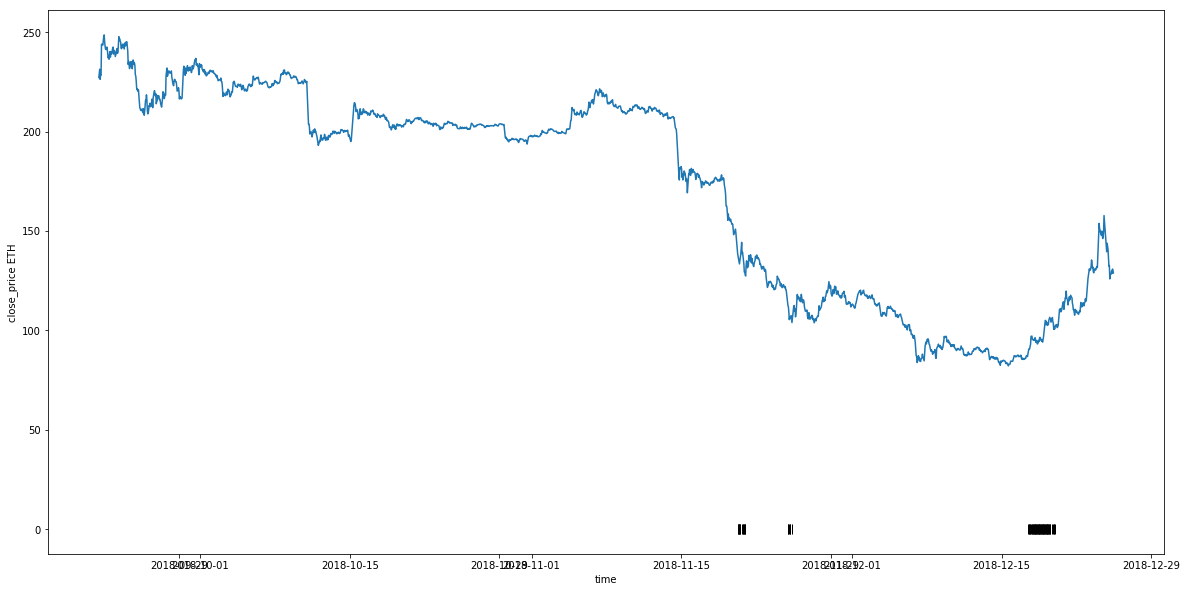

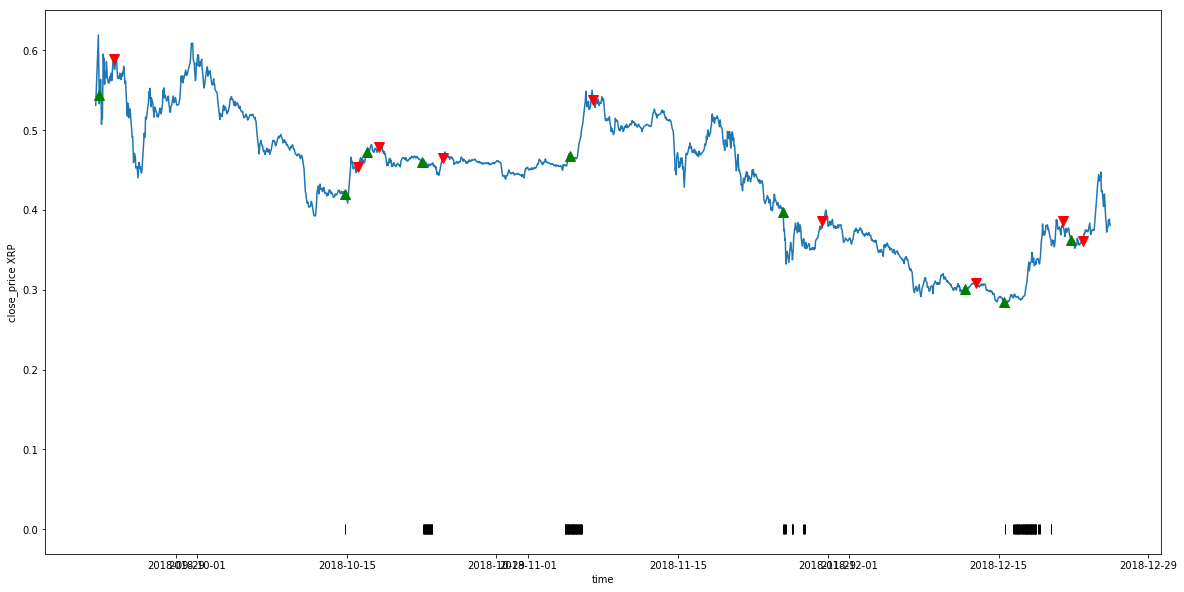

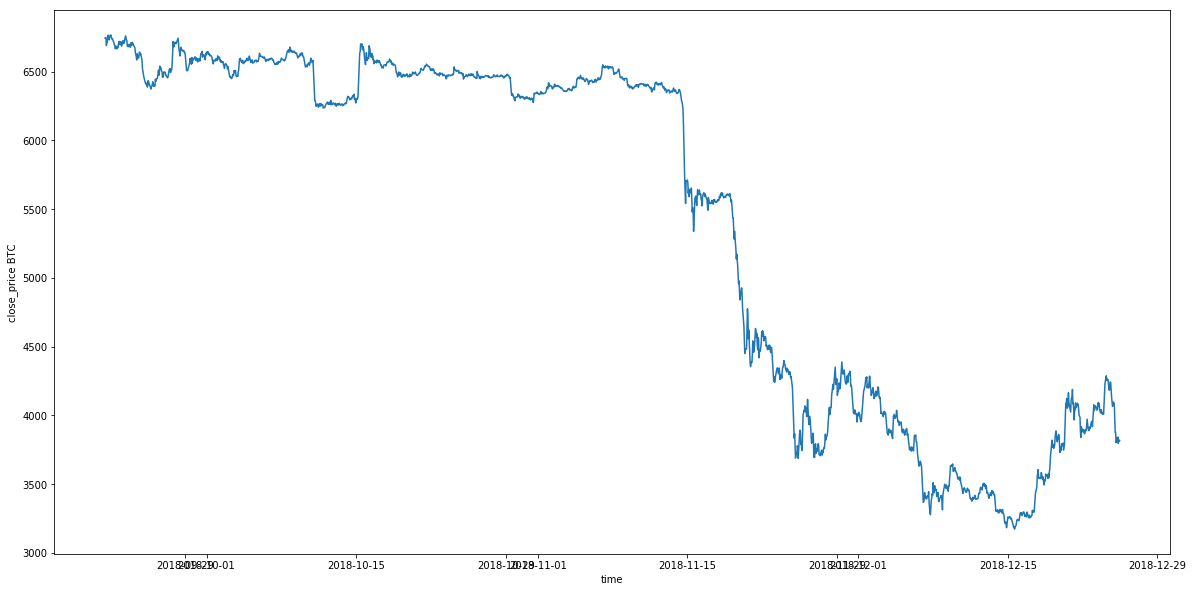

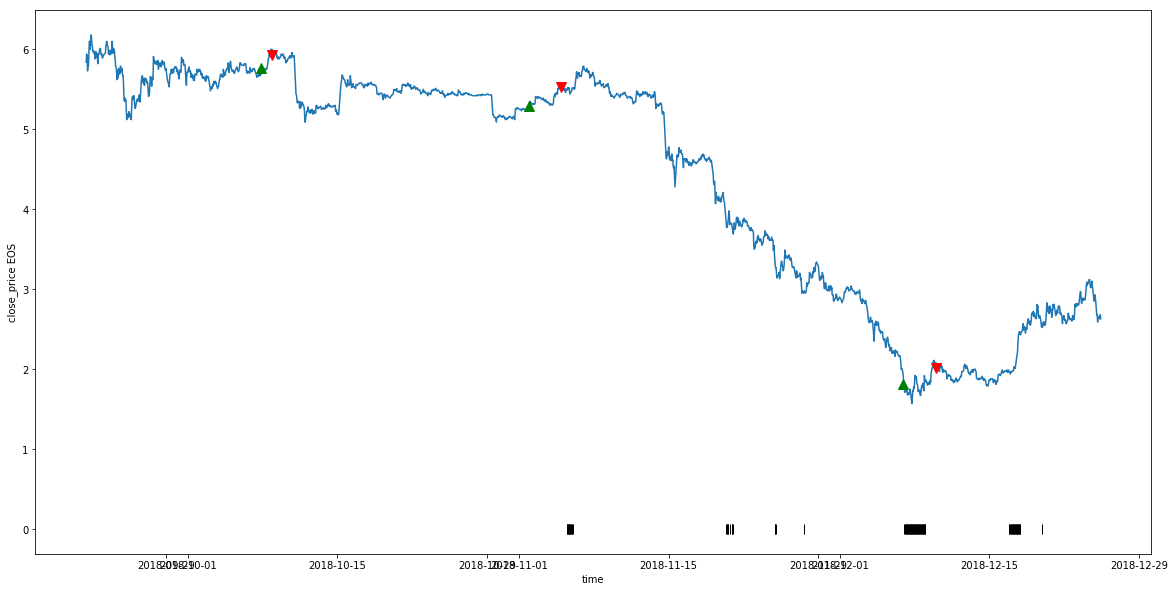

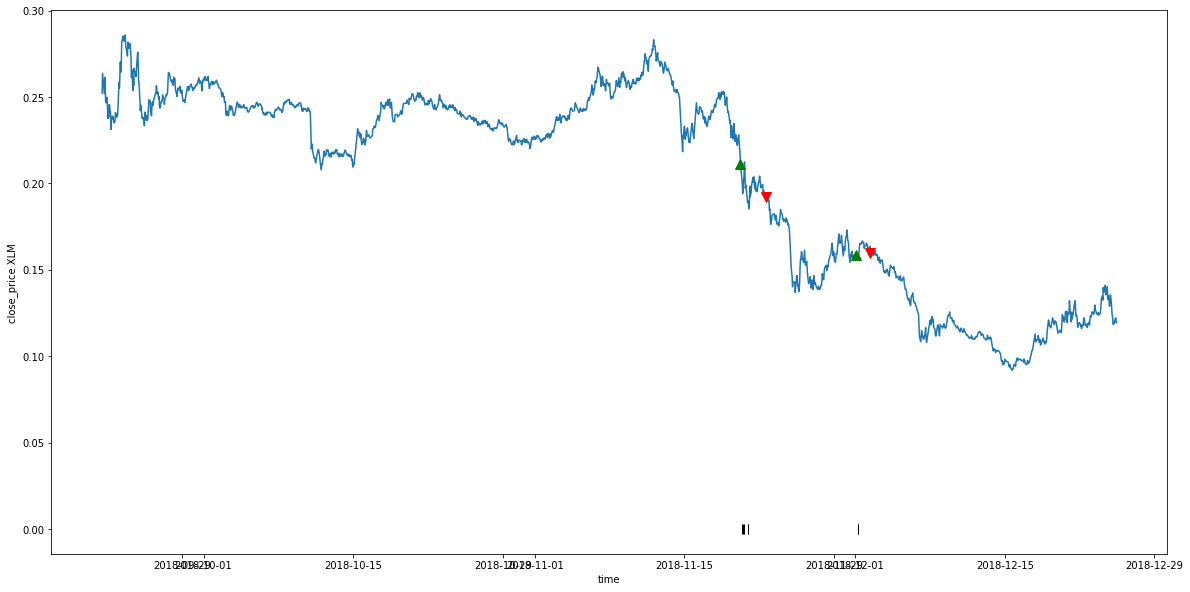

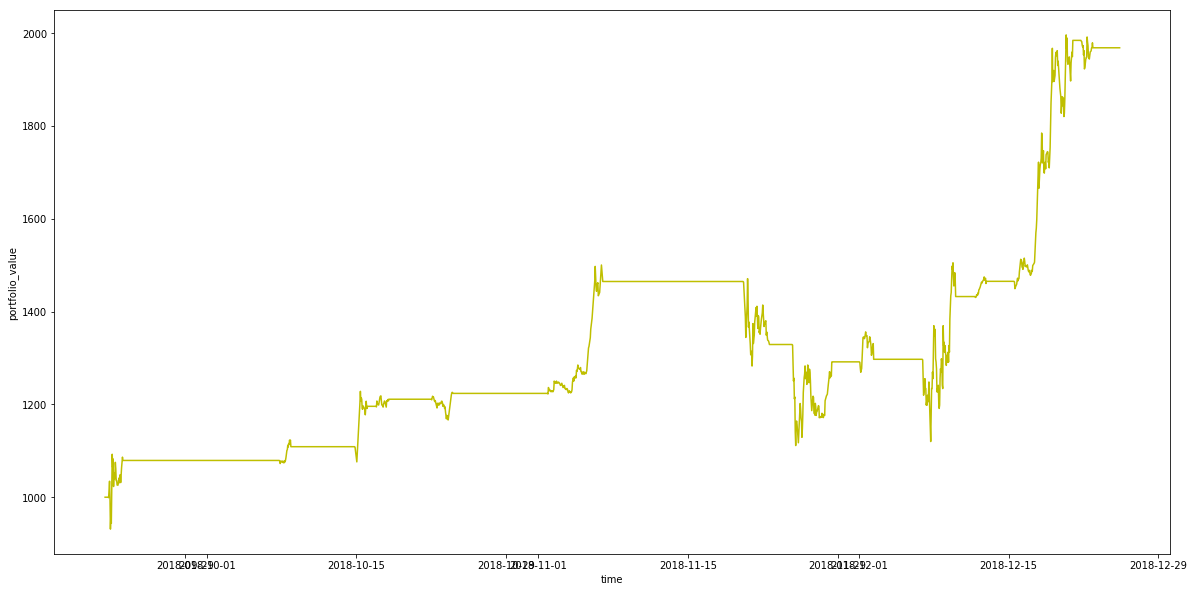

In [3]:
# Testing set
threshold = 0.82
base_asset_1 = 'ETH'
quote_asset_1 = 'USDT'
trading_pair_1 = base_asset_1 + quote_asset_1
pair_1 = TradingPair(trading_pair_1, base_asset_1, quote_asset_1)

base_asset_2 = 'XRP'
quote_asset_2 = 'USDT'
trading_pair_2 = base_asset_2 + quote_asset_2
pair_2 = TradingPair(trading_pair_2, base_asset_2, quote_asset_2)

base_asset_3 = 'BTC'
quote_asset_3 = 'USDT'
trading_pair_3 = base_asset_3 + quote_asset_3
pair_3 = TradingPair(trading_pair_3, base_asset_3, quote_asset_3)

base_asset_4 = 'EOS'
quote_asset_4 = 'USDT'
trading_pair_4 = base_asset_4 + quote_asset_4
pair_4 = TradingPair(trading_pair_4, base_asset_4, quote_asset_4)

base_asset_5 = 'XLM'
quote_asset_5 = 'USDT'
trading_pair_5 = base_asset_5 + quote_asset_5
pair_5 = TradingPair(trading_pair_5, base_asset_5, quote_asset_5)

trading_pairs = {trading_pair_1: pair_1, trading_pair_2: pair_2, trading_pair_3: pair_3, trading_pair_4: pair_4, trading_pair_5: pair_5}
thresholds = {trading_pair_1: threshold, trading_pair_2: threshold, trading_pair_3: threshold, trading_pair_4: threshold, trading_pair_5: threshold}

init_date = y_test_1.index.get_level_values(0).min()
end_date = y_test_1.index.get_level_values(0).max()

X_tests = {trading_pair_1: X_test_1, trading_pair_2: X_test_2, trading_pair_3: X_test_3, trading_pair_4: X_test_4, trading_pair_5: X_test_5}
X_closes = {trading_pair_1: X_test_close_price_1, trading_pair_2: X_test_close_price_2, trading_pair_3: X_test_close_price_3, trading_pair_4: X_test_close_price_4, trading_pair_5: X_test_close_price_5}

backtest = BacktestingStrategy(model_1, 24, init_date, end_date, X_tests, X_closes, close_price_increase_targeted, thresholds, trading_pairs, quote_asset_1)
# backtest.override_signals(y_test)
backtest.do_backtest()
prices= backtest.show_graphs()

[BUY] ORDER PLACED (2017-12-07 16:00:00+00:00): 2.3985594237695076 ETH for 1000.0$ (close_price = 416.5$ / fees = 1.0)
[SELL] ORDER PLACED (2017-12-09 17:00:00+00:00): 2.3985594237695076 ETH for 1149.6156825306123$ (close_price = 479.77$ / fees = 1.15)
[BUY] ORDER PLACED (2017-12-10 07:00:00+00:00): 2.6231466512449906 ETH for 1149.6156825306123$ (close_price = 437.82$ / fees = 1.15)
[SELL] ORDER PLACED (2017-12-21 09:00:00+00:00): 2.6231466512449906 ETH for 2175.47999780859$ (close_price = 830.17$ / fees = 2.18)
[BUY] ORDER PLACED (2017-12-22 15:00:00+00:00): 292.8981829933668 EOS for 2175.47999780859$ (close_price = 7.42$ / fees = 2.18)
[SELL] ORDER PLACED (2017-12-27 13:00:00+00:00): 292.8981829933668 EOS for 2583.7046648755972$ (close_price = 8.83$ / fees = 2.59)
[BUY] ORDER PLACED (2017-12-28 06:00:00+00:00): 324.26142716215094 EOS for 2583.7046648755972$ (close_price = 7.96$ / fees = 2.58)
[SELL] ORDER PLACED (2018-01-07 15:00:00+00:00): 324.26142716215094 EOS for 3232.89291403518

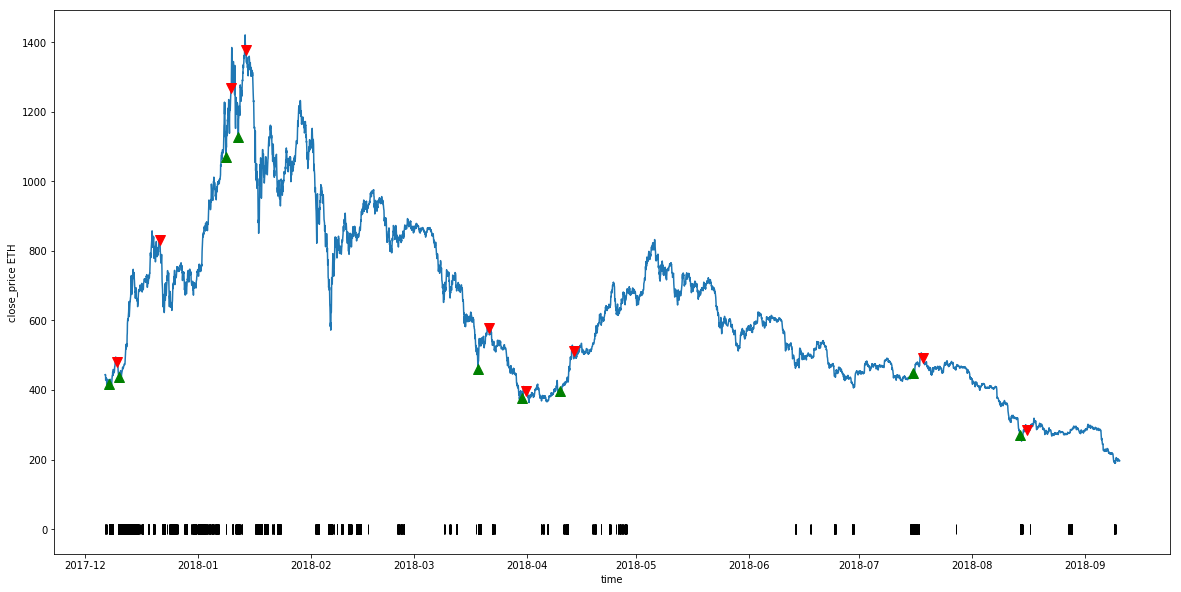

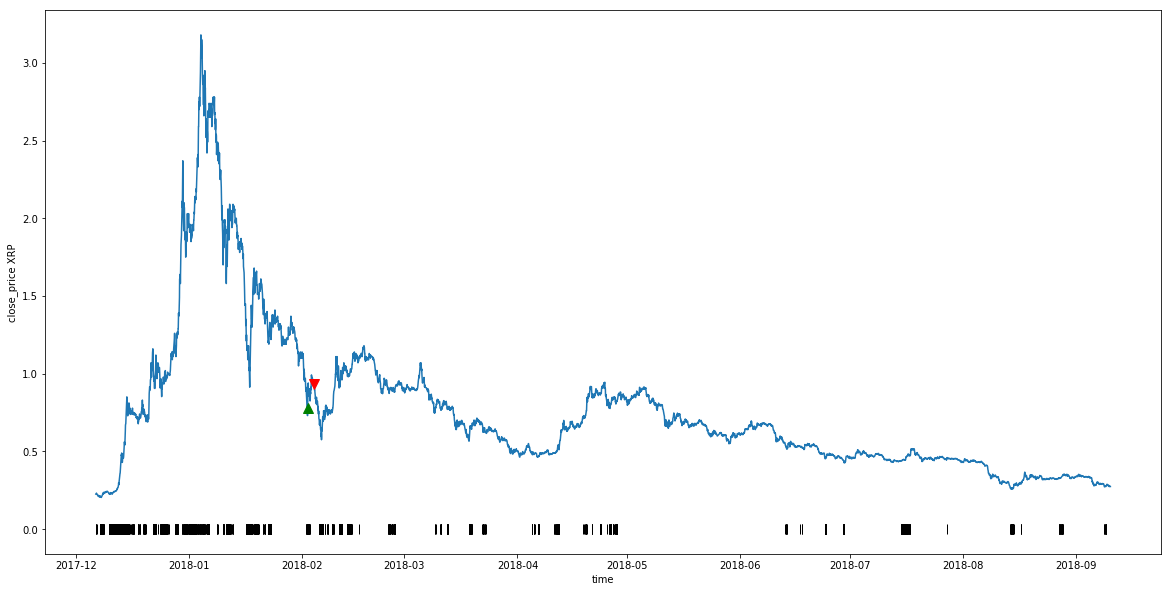

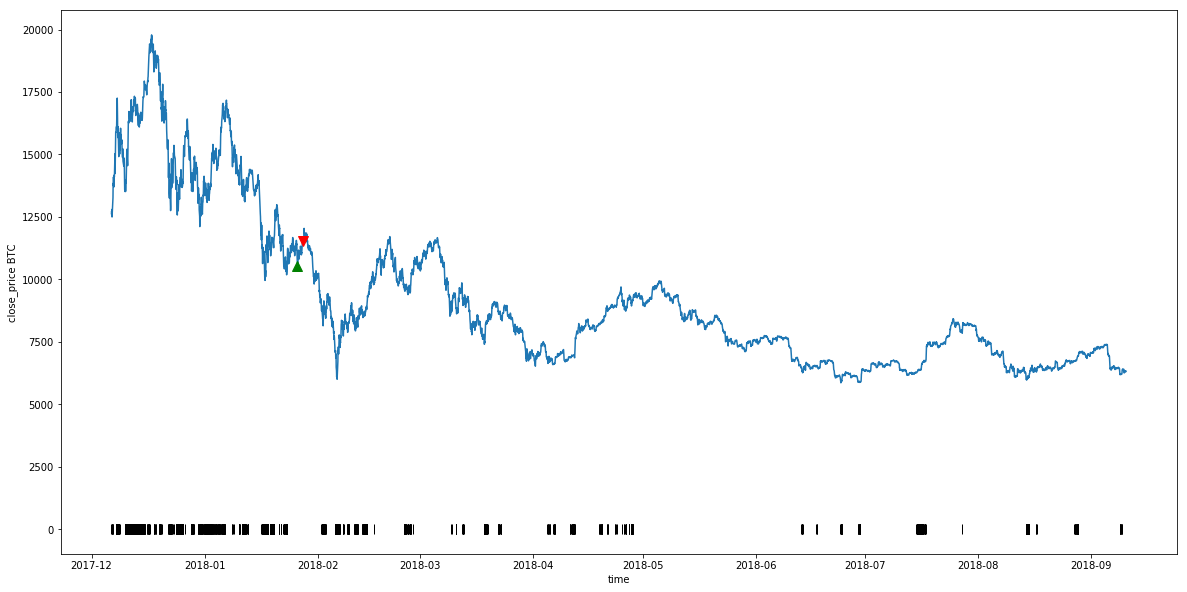

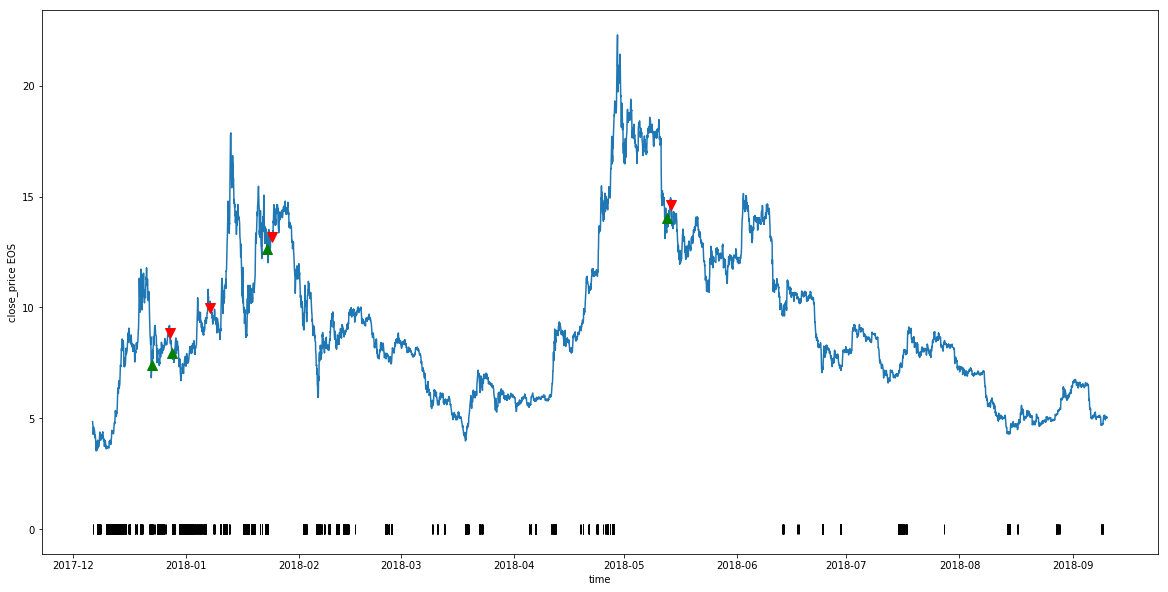

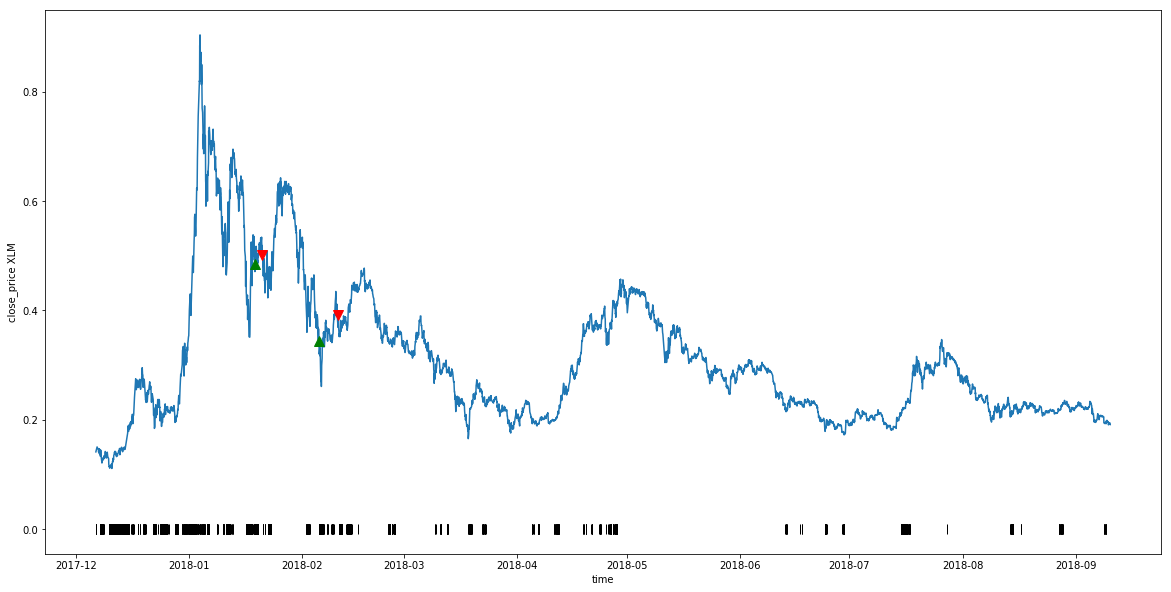

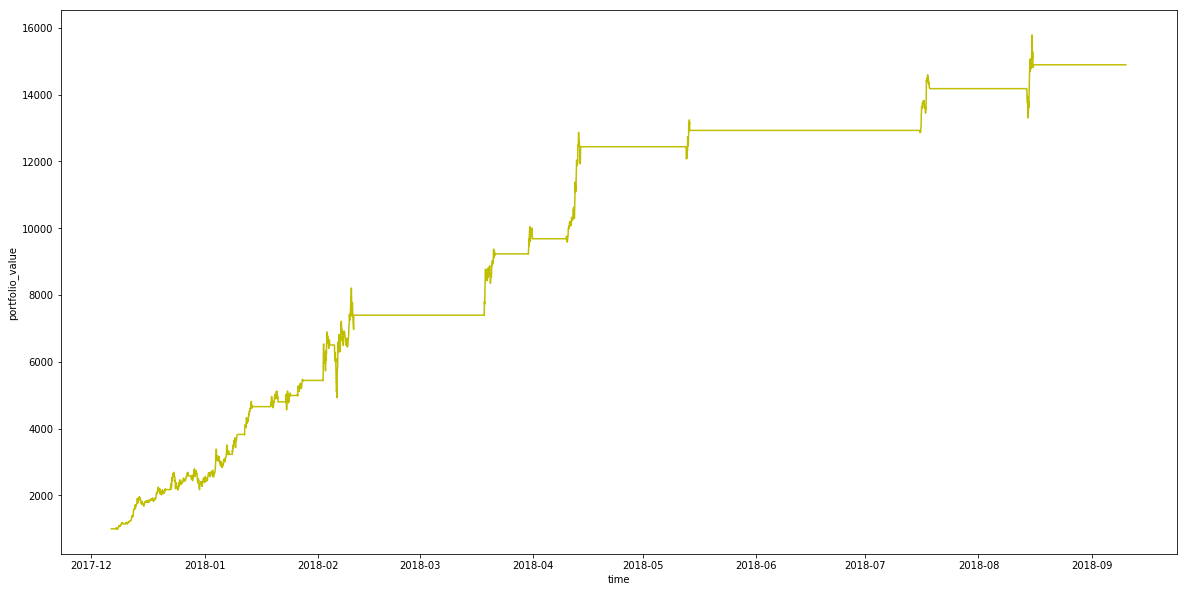

In [6]:
# Training set
threshold = 0.82
base_asset_1 = 'ETH'
quote_asset_1 = 'USDT'
trading_pair_1 = base_asset_1 + quote_asset_1
pair_1 = TradingPair(trading_pair_1, base_asset_1, quote_asset_1)

base_asset_2 = 'XRP'
quote_asset_2 = 'USDT'
trading_pair_2 = base_asset_2 + quote_asset_2
pair_2 = TradingPair(trading_pair_2, base_asset_2, quote_asset_2)

base_asset_3 = 'BTC'
quote_asset_3 = 'USDT'
trading_pair_3 = base_asset_3 + quote_asset_3
pair_3 = TradingPair(trading_pair_3, base_asset_3, quote_asset_3)

base_asset_4 = 'EOS'
quote_asset_4 = 'USDT'
trading_pair_4 = base_asset_4 + quote_asset_4
pair_4 = TradingPair(trading_pair_4, base_asset_4, quote_asset_4)

base_asset_5 = 'XLM'
quote_asset_5 = 'USDT'
trading_pair_5 = base_asset_5 + quote_asset_5
pair_5 = TradingPair(trading_pair_5, base_asset_5, quote_asset_5)

trading_pairs = {trading_pair_1: pair_1, trading_pair_2: pair_2, trading_pair_3: pair_3, trading_pair_4: pair_4, trading_pair_5: pair_5}
thresholds = {trading_pair_1: threshold, trading_pair_2: threshold, trading_pair_3: threshold, trading_pair_4: threshold, trading_pair_5: threshold}

init_date = y_train_1.index.get_level_values(0).min()
end_date = y_train_1.index.get_level_values(0).max()

X_tests = {trading_pair_1: X_train_1, trading_pair_2: X_train_2, trading_pair_3: X_train_3, trading_pair_4: X_train_4, trading_pair_5: X_train_5}
X_closes = {trading_pair_1: X_train_close_price_1, trading_pair_2: X_train_close_price_2, trading_pair_3: X_train_close_price_3, trading_pair_4: X_train_close_price_4, trading_pair_5: X_train_close_price_5}

backtest = BacktestingStrategy(model_1, 24, init_date, end_date, X_tests, X_closes, close_price_increase_targeted, thresholds, trading_pairs, quote_asset_1)
# backtest.override_signals(y_test)
backtest.do_backtest()
prices= backtest.show_graphs()

In [2]:
import import_ipynb
import algocryptos_preprocessing as alg_preproc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

dict_hours_labels  = {24:'1d'}
predict_only_one_crypto = True
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
id_cryptocompare_1 = "7605"
id_cryptocompare_2 = "5031"
id_cryptocompare_3 = "1182"
id_cryptocompare_4 = "166503"
id_cryptocompare_5 = "4614"

dict_df = load_obj('dict_df_2018_12_26_top10')

def train_model(X_, y_):
    scale_pos_weight = y_.value_counts()[False] / y_.value_counts()[True]
    
#     xgbc = XGBClassifier(booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.9, gamma=0.0, learning_rate=0.01,
#        max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
#        n_estimators=600, nthread=-1,
#        objective='binary:logistic', random_state=0, reg_alpha=0.01,
#        reg_lambda=1, scale_pos_weight=4.0270621065611, seed=27,
#        silent=True, subsample=0.9).fit(X_.values, y_.values)
    
    
#     xgbc = RandomForestClassifier(bootstrap=False, class_weight='balanced',
#             criterion='gini', max_depth=5, max_features='sqrt',
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=1,
#             min_samples_split=10, min_weight_fraction_leaf=0.0,
#             n_estimators=50, oob_score=False, random_state=0,
#             verbose=0, warm_start=False).fit(X_.values, y_.values)

    xgbc = XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight, silent=True).fit(X_.values, y_.values)
    return xgbc

useless_features = load_obj('useless_features')

X_train_1, X_test_1, y_train_1, y_test_1, X_train_close_price_1, X_test_close_price_1 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_1,
                                                                     useless_features=useless_features)

X_train_2, X_test_2, y_train_2, y_test_2, X_train_close_price_2, X_test_close_price_2 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_2,
                                                                     useless_features=useless_features)

X_train_3, X_test_3, y_train_3, y_test_3, X_train_close_price_3, X_test_close_price_3 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_3,
                                                                     useless_features=useless_features)

X_train_4, X_test_4, y_train_4, y_test_4, X_train_close_price_4, X_test_close_price_4 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_4,
                                                                     useless_features=useless_features)

X_train_5, X_test_5, y_train_5, y_test_5, X_train_close_price_5, X_test_close_price_5 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_5,
                                                                     useless_features=useless_features)

X_train_close_price_1, X_test_close_price_1 = format_both_close_prices(X_train_close_price_1, X_test_close_price_1, id_cryptocompare_1)
X_train_close_price_2, X_test_close_price_2 = format_both_close_prices(X_train_close_price_2, X_test_close_price_2, id_cryptocompare_2)
X_train_close_price_3, X_test_close_price_3 = format_both_close_prices(X_train_close_price_3, X_test_close_price_3, id_cryptocompare_3)
X_train_close_price_4, X_test_close_price_4 = format_both_close_prices(X_train_close_price_4, X_test_close_price_4, id_cryptocompare_4)
X_train_close_price_5, X_test_close_price_5 = format_both_close_prices(X_train_close_price_5, X_test_close_price_5, id_cryptocompare_5)

model_1 = train_model(X_train_1, y_train_1[y_to_be_considered])
#model_2 = train_model(X_train_2, y_train_2[y_to_be_considered])
# TODO : Pourquoi X_train1 et X_train 2 sont différents ? 
# pd.DataFrame(X_train_1).describe() vs pd.DataFrame(X_train_2).describe()

importing Jupyter notebook from algocryptos_preprocessing.ipynb
